In [2]:
import os
os.chdir("../")

In [3]:
import sys
sys.path.append(os.getcwd())

In [4]:
import matplotlib.pyplot as plt
import torch

import einops
import numpy as np
from datasets import Dataset
from PIL import Image
from tqdm import tqdm

SMALL_SIZE = 22
MEDIUM_SIZE = 24
BIGGER_SIZE = 26
plt.rc("font", size=SMALL_SIZE, family="Times New Roman")  # controls default text sizes
plt.rc(
	"axes", titlesize=BIGGER_SIZE, labelsize=MEDIUM_SIZE
)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE, labelsize=SMALL_SIZE)  # f

colors = ["#386EC2", "#B5B5B2", "#990006", "#625D0A", "#B9741F", "#213958"]

torch.set_grad_enabled(False)

/Users/mikolajpiorczynski/miniconda3/envs/sae-diff-autointerpr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
dtype = torch.float16
device = "mps" if torch.backends.mps.is_available() else "cuda"
ckpt_path = "checkpoints/coco2017/sdxl-turbo/batch_topk_expansion_factor16_k32_multi_topkFalse_auxk_alpha0.03125_output"
hookpoint = "down_blocks.2"

In [6]:
from src.sae.sae import Sae

sae = Sae.load_from_disk(
	os.path.join(
		ckpt_path,
		hookpoint,
	),
	device=device,
).to(dtype)

Triton not installed, using eager implementation of SAE decoder.


In [7]:
num_params = 0
for n, m in sae.named_parameters():
	print(f"{n}: {m.shape}")
	num_params += m.numel()
	
print("="*50)
print(f"Total number of parameters: {num_params / 1e6:.2f}M")

W_dec: torch.Size([20480, 1280])
b_dec: torch.Size([1280])
encoder.weight: torch.Size([20480, 1280])
encoder.bias: torch.Size([20480])
Total number of parameters: 52.45M


In [8]:
activations_dataset_path = "activations/coco2017/sdxl-turbo/"
activations_dataset = Dataset.load_from_disk(
	os.path.join(activations_dataset_path, hookpoint), keep_in_memory=False
)
activations_dataset.set_format(
	type="torch", columns=["activations", "timestep", "file_name"], dtype=dtype
)

In [9]:
activations_dataset

Dataset({
    features: ['activations', 'timestep', 'file_name'],
    num_rows: 512
})

In [10]:
dtype = torch.float16

In [11]:
num_timesteps = 1

## Most activating examples per neuron

In [23]:
avg_activations_per_sample = torch.zeros(
	(len(activations_dataset), sae.num_latents), dtype=torch.float16
)

batch_size = 16
dl = torch.utils.data.DataLoader(
	activations_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)
with torch.no_grad():
	for i, batch in tqdm(enumerate(dl), total=len(dl)):
		acts = batch["activations"].to(sae.device)
		acts = einops.rearrange(
			acts,
			"batch sample_size d_model -> (batch sample_size) d_model",
		)
		out = sae.pre_acts(acts)
		# Reshape to get per-sample activations and compute mean for each sample
		out = out.view(
			batch["activations"].shape[0], -1, sae.num_latents
		)  # [batch, sample_size, num_latents]
		batch_avg_activations = out.mean(dim=1).to(
			dtype=torch.float16
		)  # [batch, num_latents]

		# Store in the correct indices
		start_idx = i * batch_size
		end_idx = min(start_idx + batch_size, len(activations_dataset))
		avg_activations_per_sample[start_idx:end_idx] = batch_avg_activations


100%|██████████| 32/32 [00:28<00:00,  1.11it/s]


In [24]:
avg_activations_per_sample.shape

torch.Size([512, 20480])

In [25]:
def find_topk_activating_examples(activations_per_sample, latent_idx, k=10):
	topk_indices = torch.argsort(
		activations_per_sample[:, latent_idx], dim=0, descending=True
	)[:k]
	return topk_indices


In [26]:
dataset_path = "data/coco2017"

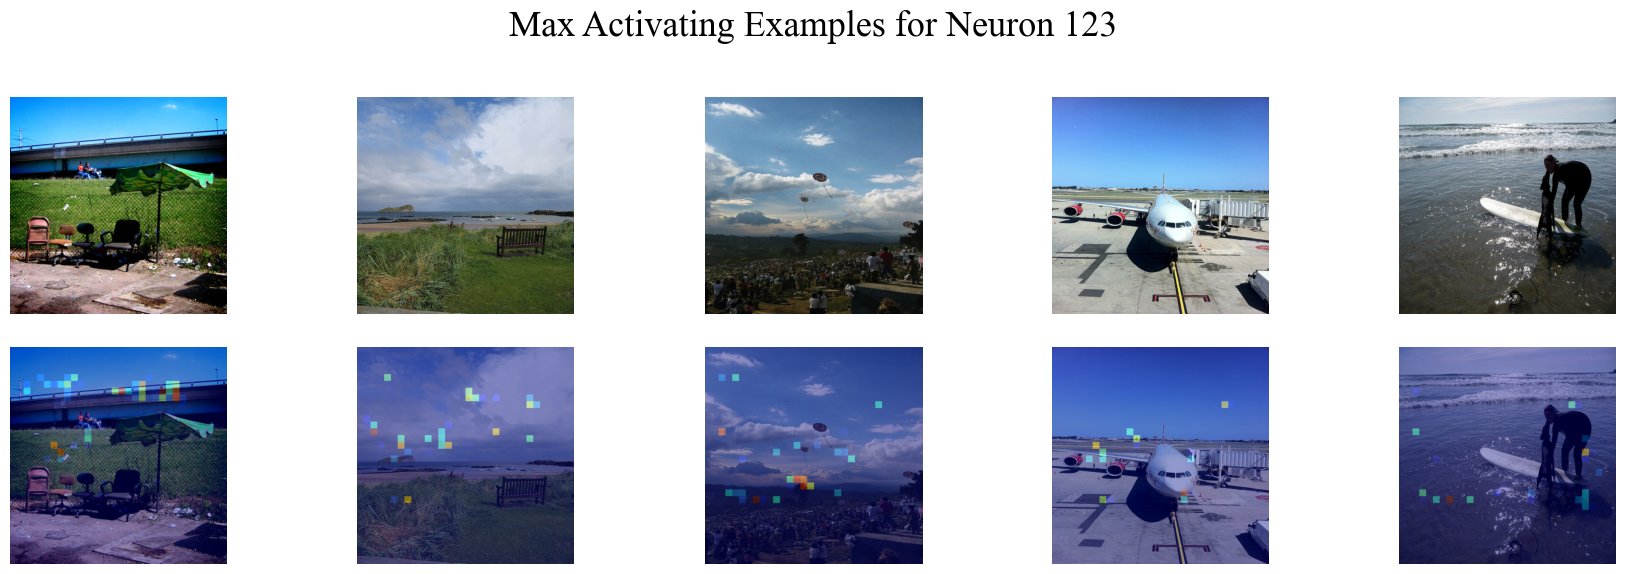

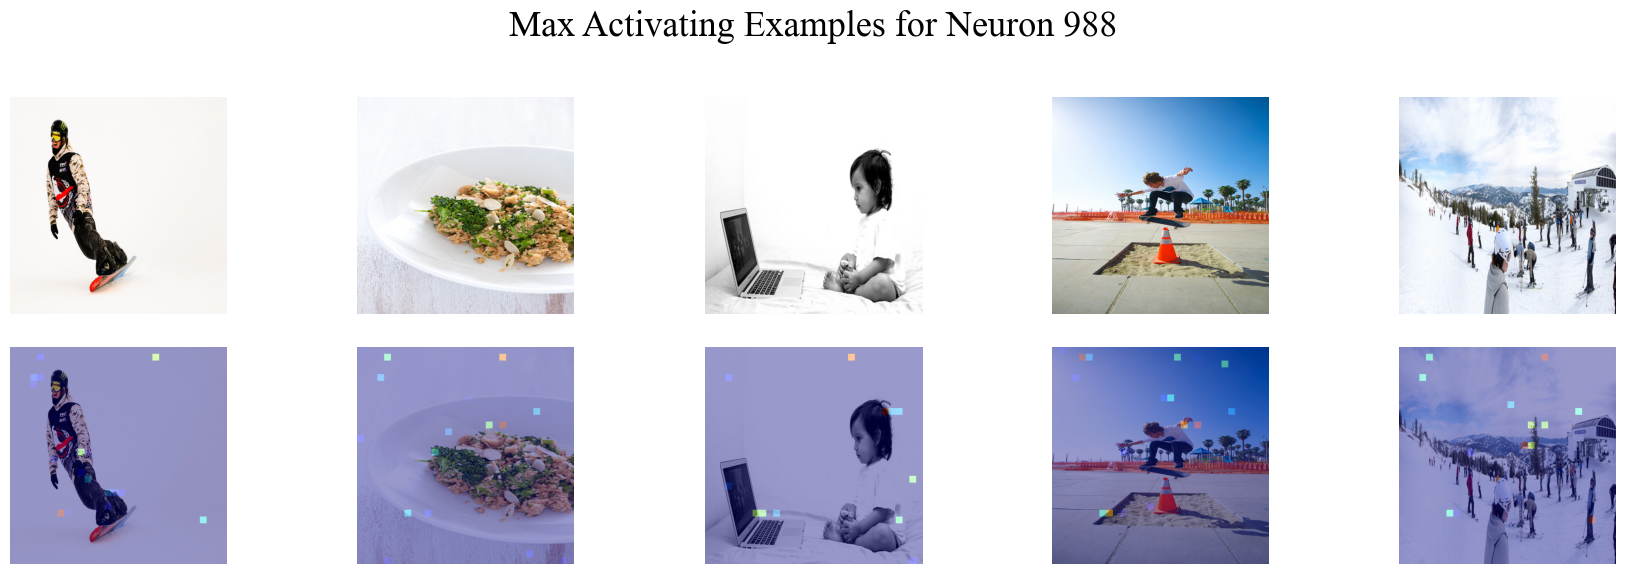

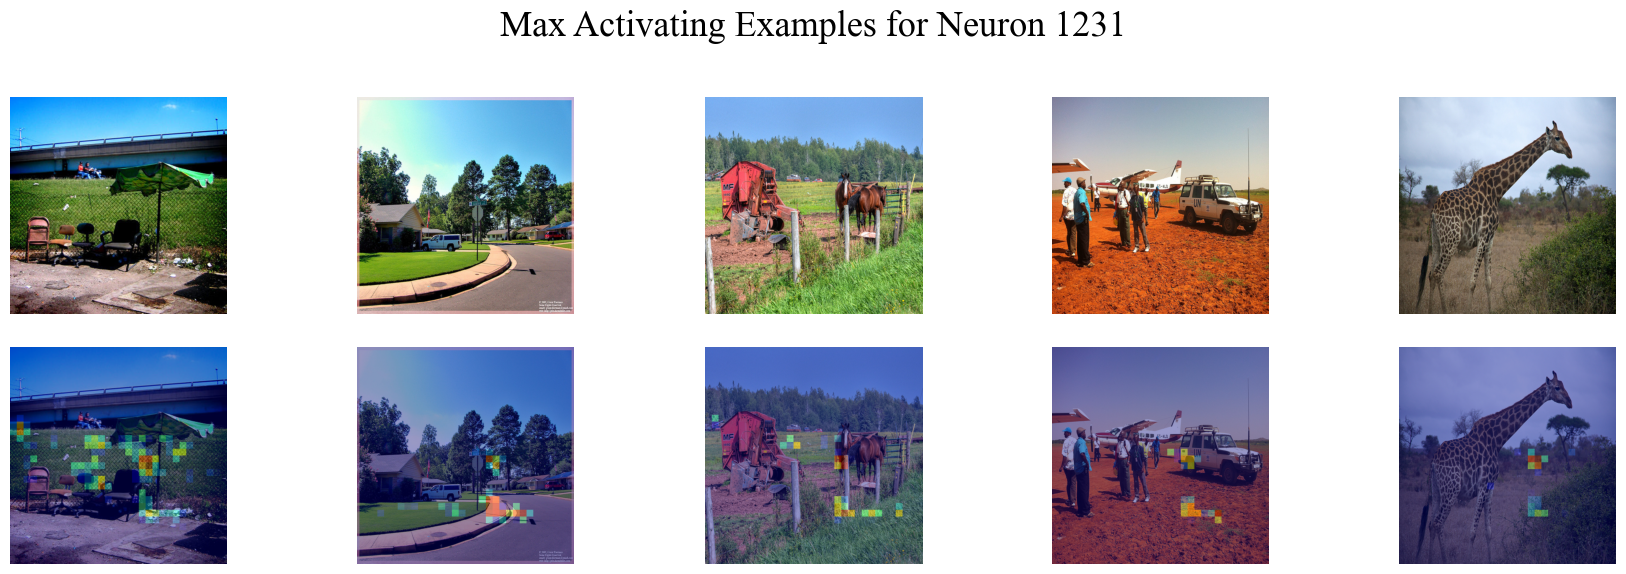

In [27]:
from tqdm import trange
k = 5
# for latent_idx in trange(sae.num_latents, desc="Plotting max activating examples for latent neurons"):
for latent_idx in [123, 988, 1231]:
	topk_indices = find_topk_activating_examples(
		avg_activations_per_sample, latent_idx, k
	)  # find topk samples containing patches with higest activations
	topk_samples = activations_dataset[topk_indices.tolist()]
	sae_latents = []
	activations = topk_samples["activations"].to(sae.device)
	timesteps = topk_samples["timestep"]
	file_names_topk = topk_samples["file_name"]
	activations = einops.rearrange(
		activations,
		"batch sample_size d_model -> (batch sample_size) d_model",
	)
	out = sae.pre_acts(activations)
	sae_latents = out.view(k, -1, sae.num_latents)


	fig, axes = plt.subplots(2, len(topk_indices), figsize=(18, 6))

	# Plot max activating examples in two rows:
	# Row 1: Original images
	# Row 2: Model activations
	for i in range(len(topk_indices)):
		# Model 1 images
		img = Image.open(os.path.join(dataset_path, file_names_topk[i]))
		img = img.resize((512, 512))
		img = img.convert("RGB")

		# Process activations for model 1
		sae_latent_activations = sae_latents[i].reshape(
			int(torch.sqrt(torch.tensor(sae_latents.shape[1])).item()),
			int(torch.sqrt(torch.tensor(sae_latents.shape[1])).item()),
			-1,
		)[:, :, latent_idx]
		# Convert latent activations to numpy and normalize
		activation_map = sae_latent_activations[:, :].detach().cpu().numpy()
		activation_map = (activation_map - activation_map.min()) / (
			activation_map.max() - activation_map.min() + 1e-8
		)

		# Calculate upscale factor to match image size for model 1
		patch_size = 512 // activation_map.shape[0]
		activation_map = np.kron(activation_map, np.ones((patch_size, patch_size)))

		# Create heatmap overlays
		heatmap = np.uint8(plt.cm.jet(activation_map)[..., :3] * 255)
		heatmap = Image.fromarray(heatmap)

		# Blend original images with heatmaps
		blended_img = Image.blend(img, heatmap, alpha=0.4)

		# Calculate average activation for the image
		avg_activation = sae_latent_activations.mean().item()

		# Row 1: Original images
		axes[0, i].imshow(img)
		axes[0, i].axis("off")
		# axes[0, i].set_title(
		#     f"Activation: {avg_activation:.2f}\nTimestep: {int(timesteps[i].item())}",
		#     fontsize=SMALL_SIZE,
		# )
		if i == 0:
			axes[0, 0].set_ylabel("Original Images", fontsize=SMALL_SIZE)

		# Row 2: Activations
		axes[1, i].imshow(blended_img)
		axes[1, i].axis("off")
		if i == 0:
			axes[1, 0].set_ylabel("Activations", fontsize=SMALL_SIZE)

	plt.suptitle(f"Max Activating Examples for Neuron {latent_idx}", fontsize=BIGGER_SIZE)
	plt.tight_layout()
	plt.savefig(
		f"figures/coco2017_sdxl-turbo_topk_activating_examples_{latent_idx}.png",
		bbox_inches="tight",
	)


## Dead features

In [29]:
avg_activations = avg_activations_per_sample.mean(dim=0).cpu().numpy()

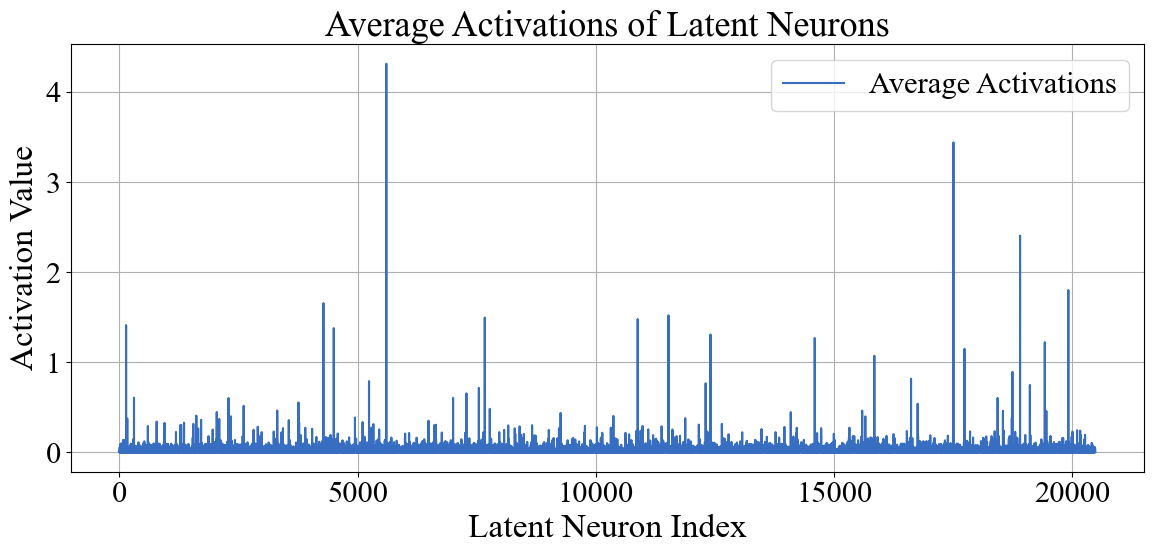

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(
    np.arange(len(avg_activations)),
    avg_activations,
    color=colors[0],
    label="Average Activations",
)
ax.set_xlabel("Latent Neuron Index", fontsize=MEDIUM_SIZE)
ax.set_ylabel("Activation Value", fontsize=MEDIUM_SIZE)
ax.set_title("Average Activations of Latent Neurons", fontsize=BIGGER_SIZE)
ax.legend()
plt.grid()
plt.tight_layout()
# plt.savefig(
#     "figures/coco2017_sdxl-turbo_average_activations.png",
#     bbox_inches="tight",
# )
plt.show()